#### R version

In [1]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.0                         
year           2019                        
month          04                          
day            26                          
svn rev        76424                       
language       R                           
version.string R version 3.6.0 (2019-04-26)
nickname       Planting of a Tree          

#### Libraries and plotting functions

In [42]:
# Dace Apšvalka @MRC-CBU, 2019
# ----------------------------------------------------------------------
# LIBRARIES
# ----------------------------------------------------------------------
library(Hmisc) 
library(plyr)      # for ddply (aggregating SST results)
library(pastecs)   # for summary statistic
library(ggplot2)   # for plotting results
library(repr)      # for changing plot size (default too large in notebook)
library(gridExtra) # for adding plots together
library(grid)      # for plot grid title formatting
library(aplpack)   # for bi-variate outlier, bgplot
library(robust)    # for robust correlation

# ----------------------------------------------------------------------
# PLOTTING FUNCTIONS
# ----------------------------------------------------------------------

# 1. PLOTTING MEANS, Group mean (with 95%CI) and subject values
# ------------------------------------
plotResults <- function(dataset, x, group, title, units, extraTxt) {
  ggplot(dataset, aes(group, x)) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = 1, stroke = 0.1, shape = 21,
      position = position_jitter(height = 0, width = 0.1)
    ) +
    stat_summary(
      fun.data = mean_cl_boot,
      geom = "pointrange",
      fill = 'red', alpha = 0.8, color = "black",
      size = 0.6, stroke = 0.3, shape = 21,
      position = position_nudge(x = -0.2)
    ) +
    # scale_x_discrete() +
    labs(x = extraTxt, y = units) + ggtitle(title) +
    theme_minimal() +
    theme(text = element_text(size = 9), 
          plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
          plot.background = element_rect(color = "lightgrey", size = 0.4, linetype = "dotted"), 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    )
}

# 2. PLOTTING CORRELATIONS (with 95%CI)
# ------------------------------------
plotCorrelation <- function(dataset, x, y, xLabel, yLabel, resTXT, pointsize, txtsize) {
  ggplot(dataset, aes(x, y)) +
    geom_smooth(
      method = lm, level = 0.95,
      color = "black", fill = "grey", size = 0.2
    ) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = pointsize, stroke = 0.2, shape = 21
    ) +
    labs(x = xLabel, y = yLabel) + ggtitle(resTXT) + 
    theme_minimal() + 
    theme(text = element_text(size = txtsize), 
          plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
          plot.background = element_rect(colour = "lightgrey", size = 0.4, linetype = "dotted"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    )
}

#### Load the data

In [3]:
# ----------------------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------------------

# SST
dataSST <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/SSTraw.csv')
# exclude Go only runs from the analysis
dataSST <- subset(dataSST, cond == '2') 

# TNT
dataTNT <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/TNT.csv')
# turn test values into percentages
dataTNT[, 10:ncol(dataTNT)] <- dataTNT[, 10:ncol(dataTNT)] * 100

# tfSSRT: SSRTs with Stop trigger failures
data_tfSSRT <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/TF_SSRT.csv')

# Behavioural performance

For the statistical analyses of the behavioural data, we used R (v3.5.2, 2018-12-20) in RStudio (v1.1.463, RStudio, Inc, Boston, MA). The data and detailed analysis notebook are freely available at …   The significance threshold for all statistical comparisons was p < 0.05.

## Stop-signal task performance
For the analysis of Stop-signal task data, we followed the guidelines by Verbruggen et al. (2019) and calculated SSRT using integration method with the replacement of Go omissions. Specifically, we included all Stop trials and all Go trials (correct and incorrect), replacing missed Go responses with the maximum Go RT. To identify the nth fastest Go RT, we multiplied the number of total Go trials by the probability of responding to stop signal (unsuccessful stopping). The estimated SSRT was a difference between the nth fastest Go RT and the mean SSD.

In addition to SSRT, we calculated the probability of Go omissions, probability of choice errors on Go trials, probability of responding to Stop trials, mean SSD of all Stop trials, mean correct Go RT, and mean failed Stop RT. We also compared RTs of all Go trials against RTs of failed Stop trials to test the assumption of an independent race between a go and a stop runner. Besides, we assessed the change of Go RTs across the eight experimental blocks. Prior work suggests that the experiment-wide integration method can result in underestimation bias of SSRT if participants slow their RT gradually across experimental runs. In that case, a blocked integration method would provide a better measure of SSRT (Verbruggen et al., 2013). In our data, however, on average within the group, we observed a negligible decrease in RT across runs (B = -2.555, p = .250), yielding the experiment-wide integration method more appropriate. 

### Analysis function

In [4]:
# STOP-SIGNAL ANALYSIS
# Based on: Verbruggen et al (2019). https://doi.org/10.7554/eLife.46323.001
# ------------------------------------
funcSignal <- function(data) {
  # all trials with a Response (any)
  data$resp <- ifelse(data$gRT == "0", 0, 1)
  
  # Stop-signal trials
  # ----------------------------------------------------------------------
  # All
  signal <- subset(data, gkind == '1')
  # probability of responding to the Stop-Signal
  presp <-  mean(signal$resp)
  # mean Stop-Signal Delay (of all Stop-Signal trials)
  ssd <- mean(signal$gintVal)
  # unsuccessful Stop RTs
  signal.resp    <- subset(signal, resp == '1')
  signal.resp.rt <- mean(signal.resp$gRT)
  
  # Go trials
  # ----------------------------------------------------------------------
  # All
  nosignal <- subset(data, gkind == '0') 
  # With response
  nosignal_resp <- subset(nosignal, resp == '1') 
  # probability of Go omossions
  pmiss <- 1-mean(nosignal$resp)
  # Correct Go trials
  nosignal_resp$error <-
    ifelse(nosignal_resp$gtheButton == nosignal_resp$gresp, 0, 1)
  # Probability of Go choice errors
  perror <- mean(nosignal_resp$error)
  # for the missed responses, set RT to max RT of the subject
  nosignal$gRT <-
    ifelse(nosignal$gRT == 0, max(nosignal_resp$gRT), nosignal$gRT)
  # RT for Go trials with a response
  nosignal.resp.rt <- mean(nosignal_resp$gRT)
  # RT for correct Go trials
  nosignal.correctresp <- subset(nosignal_resp, error == '0')
  nosignal.correctresp.rt <- mean(nosignal.correctresp$gRT)
  
  # SSRT
  # ----------------------------------------------------------------------
  # All Go trials are included when the nth RT is determined
  ## determine nth RT
  nthRT_all <- quantile(nosignal$gRT, probs = presp, type = 6)
  ## SSRT(integration) = nthRT - ssd
  SSRTall <- nthRT_all - ssd
  
  # Race Check
  # ----------------------------------------------------------------------
  # All Go trials
    # "..this comparison should include all trials with a response 
    # (including choice errors and premature responses).." 
    # (Verbruggen et al., 2019))
  race.check <- nosignal.resp.rt - signal.resp.rt
  
  # Output
  # ----------------------------------------------------------------------
  return(
    data.frame(
      Ntrials = nrow(data),
      NStop = sum(signal$gkind),
      ssPerc = sum(signal$gkind)/nrow(data)*100,
      presp, pmiss, perror, 
      SSD = ssd,
      SSRT = SSRTall,
      sRT = signal.resp.rt,
      goRTcorr = nosignal.correctresp.rt,
      goRTall = nosignal.resp.rt,  
      raceCheck = race.check
    )
  )
}

### Summary data and decriptives

In [5]:
# ======================================================================
# SST RESULTS
# ======================================================================
# By Subject aggregated
# ----------------------------------------------------------------------
dataSSTsubj <- ddply(dataSST, .(sNR), funcSignal)
# display
options(width = 118) 
print(round(dataSSTsubj,2))

   sNR Ntrials NStop ssPerc presp pmiss perror    SSD   SSRT    sRT goRTcorr goRTall raceCheck
1    1     384   123  32.03  0.37  0.00   0.00 291.87 295.13 570.64   612.05  612.05     41.41
2    2     384   123  32.03  0.50  0.00   0.02 219.51 402.42 606.59   633.24  633.05     26.46
3    3     336   110  32.74  0.44  0.01   0.04 258.18 367.98 642.02   669.21  675.49     33.47
4    4     384   121  31.51  0.42  0.00   0.02 248.35 288.93 509.04   562.74  562.87     53.83
5    5     384   119  30.99  0.46  0.00   0.03 243.28 296.72 516.98   581.51  580.45     63.47
6    6     384   111  28.91  0.58  0.00   0.05 219.82 400.16 569.00   609.02  610.13     41.13
7    7     384   111  28.91  0.53  0.00   0.02 236.94 307.06 481.66   559.78  558.63     76.97
8    8     384   126  32.81  0.56  0.00   0.03 188.10 318.90 494.49   509.12  508.24     13.74
9    9     336   106  31.55  0.69  0.00   0.06 148.11 443.14 533.47   569.88  565.51     32.05
10  10     384   115  29.95  0.47  0.00   0.04 232

In [6]:
# Descriptives
# ----------------------------------------------------------------------
dscrSST <- stat.desc(dataSSTsubj[, 2:ncol(dataSSTsubj)],  basic = TRUE, desc = TRUE, p = 0.95) 
print(round(dscrSST, 2))

             Ntrials   NStop ssPerc presp pmiss perror     SSD    SSRT      sRT goRTcorr  goRTall raceCheck
nbr.val        24.00   24.00  24.00 24.00 24.00  24.00   24.00   24.00    24.00    24.00    24.00     24.00
nbr.null        0.00    0.00   0.00  0.00 17.00   1.00    0.00    0.00     0.00     0.00     0.00      0.00
nbr.na          0.00    0.00   0.00  0.00  0.00   0.00    0.00    0.00     0.00     0.00     0.00      0.00
min           336.00  106.00  28.91  0.36  0.00   0.00  148.11  271.24   458.44   489.31   489.29     -9.00
max           384.00  136.00  35.42  0.69  0.03   0.11  291.87  465.56   671.36   723.71   730.06     96.60
range          48.00   30.00   6.51  0.33  0.03   0.11  143.76  194.32   212.91   234.40   240.77    105.60
sum          9120.00 2908.00 765.33 11.71  0.06   0.97 5519.90 8360.27 13366.15 14421.82 14440.06   1073.91
median        384.00  121.50  31.90  0.50  0.00   0.04  231.53  349.03   549.09   602.90   600.17     43.88
mean          380.00  121.17

### Result plots

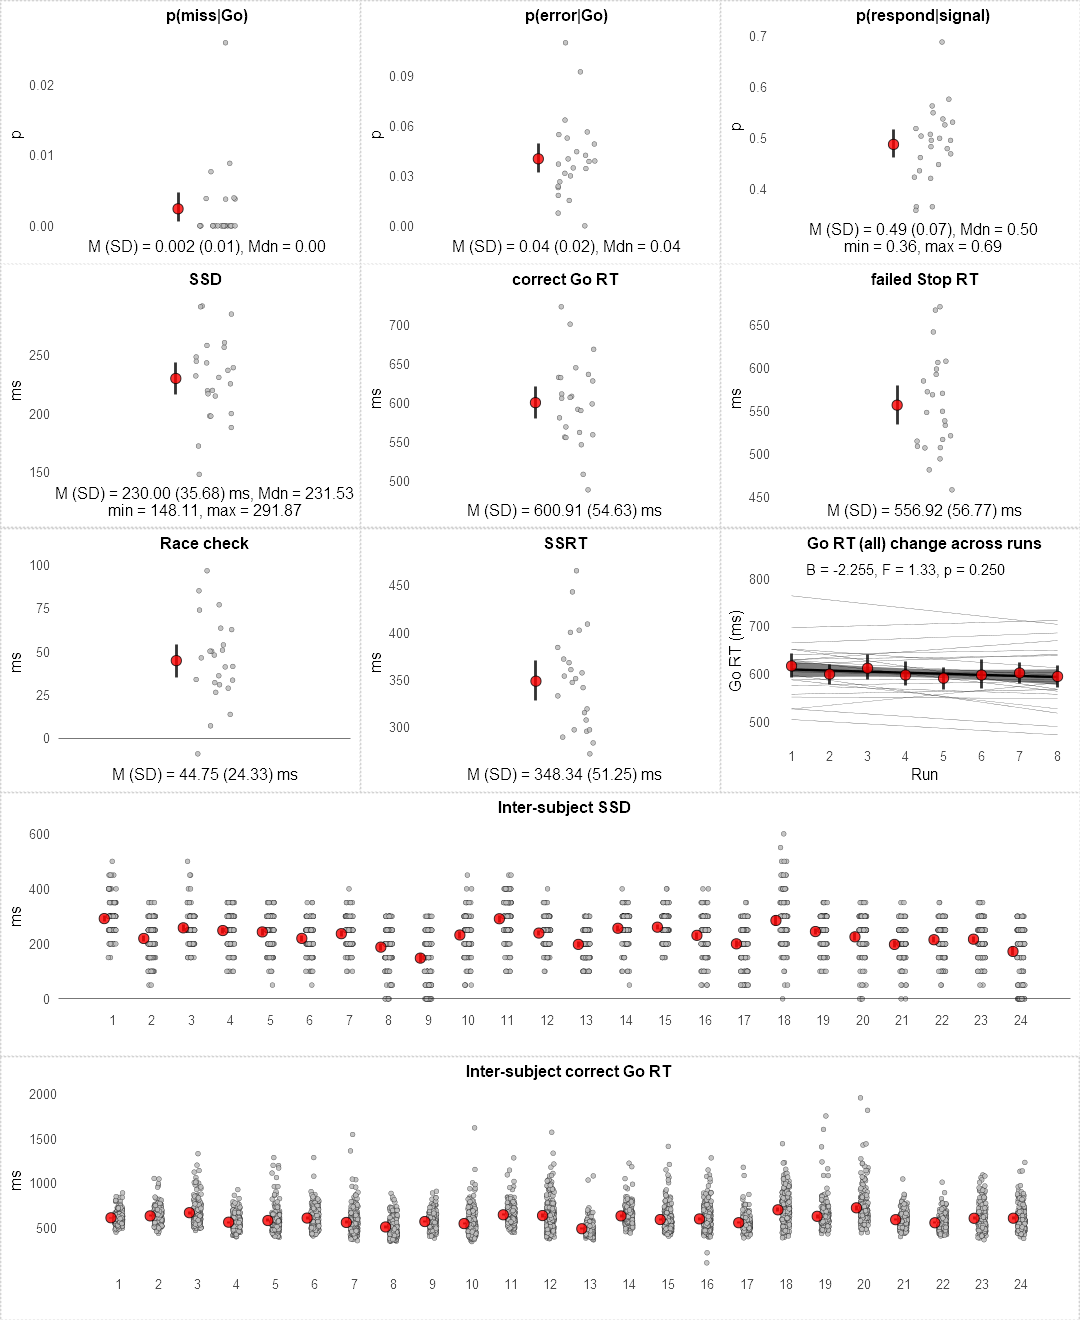

In [7]:
# Plot results
# ----------------------------------------------------------------------
options(repr.plot.width = 9, repr.plot.height = 11) 

# 1. Probability of Go omissions (no response)
p1 <- plotResults(dataSSTsubj, dataSSTsubj$pmiss, 1, "p(miss|Go)", "p", 
                   sprintf("M (SD) = %.3f (%.2f), Mdn = %.2f", 
                           dscrSST["mean","pmiss"], dscrSST["std.dev","pmiss"], dscrSST["median","pmiss"])) + 
      scale_x_discrete()

# 2. Probability of choice errors on Go trials
p2 <- plotResults(dataSSTsubj, dataSSTsubj$perror, 1, "p(error|Go)", "p",
                   sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f", 
                           dscrSST["mean","perror"], dscrSST["std.dev","perror"], dscrSST["median","perror"])) + 
      scale_x_discrete()

# 3. Probability of responding on a Stop trial
# recommended to refrain from estimating individual SSRTs when p (respond|signal) 
# is lower than 0.25 or higher than 0.75
p3 <- plotResults(dataSSTsubj, dataSSTsubj$presp, 1, "p(respond|signal)", "p",
                    sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f\nmin = %.2f, max = %.2f", 
                            dscrSST["mean","presp"], dscrSST["std.dev","presp"], dscrSST["median","presp"], 
                            dscrSST["min","presp"], dscrSST["max","presp"])) + 
      scale_x_discrete()

# 4. Average Stop-Signal Delay
p4 <- plotResults(dataSSTsubj, dataSSTsubj$SSD, 1, "SSD", "ms",
                    sprintf("M (SD) = %.2f (%.2f) ms, Mdn = %.2f\nmin = %.2f, max = %.2f", 
                            dscrSST["mean","SSD"], dscrSST["std.dev","SSD"], dscrSST["median","SSD"], 
                            dscrSST["min","SSD"], dscrSST["max","SSD"])) + 
      scale_x_discrete()

# 5. Mean RT on correct Go trials
p5 <- plotResults(dataSSTsubj, dataSSTsubj$goRTcorr, 1, "correct Go RT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","goRTcorr"], dscrSST["std.dev","goRTcorr"])) + 
      scale_x_discrete()

# 6. RT of unsuccessful Stop trials 
p6 <- plotResults(dataSSTsubj, dataSSTsubj$sRT, 1, "failed Stop RT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","sRT"], dscrSST["std.dev","sRT"])) + 
      scale_x_discrete()

# 7. Race Check (with correct Go)
p7 <- plotResults(dataSSTsubj, dataSSTsubj$raceCheck, 1, "Race check", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","raceCheck"], dscrSST["std.dev","raceCheck"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 8. Stop-signal reaction time (SSRT)
# integration method (with replacement of Go omissions) when
p8 <- plotResults(dataSSTsubj, dataSSTsubj$SSRT, 1, "SSRT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","SSRT"], dscrSST["std.dev","SSRT"])) + 
      scale_x_discrete()

# 9. Change in Go RT across runs
dataSSTsubjRun <- ddply(dataSST, .(sNR, run), funcSignal)

p9.res.lm  <- summary(lm(goRTall ~ run, data = dataSSTsubjRun))
p9.res.aov <- unlist(summary(aov(goRTall ~ run, data = dataSSTsubjRun)))
p9.rxt <- sprintf('B = %.3f, F = %.2f, p = %.3f',
        p9.res.lm$coefficients["run", "Estimate"],
        p9.res.aov["F value1"],
        p9.res.lm$coefficients["run", "Pr(>|t|)"])

p9 <- ggplot(dataSSTsubjRun, aes(x = run, y = goRTall)) +
  # subject lines
  geom_smooth(method = lm, se = FALSE, color = "black", size = 0.05) + aes(fill = factor(sNR)) + 
  # group line
  geom_smooth(colour = "black", method = lm, size = 0.5, alpha = .5, fill = "black") +
  # run means
  stat_summary(fun.data = mean_cl_boot, geom = "pointrange", fill = 'red', alpha = 0.8,
               color = "black", size = 0.6, stroke = 0.3, shape = 21) + 
  labs(x = "Run", y = "Go RT (ms)") + ggtitle("Go RT (all) change across runs") +
  scale_x_continuous(breaks = unique(dataSSTsubjRun$run)) +
  annotate("text", label= p9.rxt, x = 4, y = max(dataSSTsubjRun$goRTall), size = 3) +
  theme_minimal() +
  theme(text = element_text(size = 9), 
        plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
        plot.background = element_rect(color = "lightgrey", size = 0.4, linetype = "dotted"), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position="none")

# 10. Inter-subject variability of SSD
dataSignal <- subset(dataSST, gkind == '1')
p10 <- plotResults(dataSignal, dataSignal$gintVal, dataSignal$sNR, "Inter-subject SSD", "ms", "") + 
  geom_hline(aes(yintercept = 0), size = 0.1) + scale_x_continuous(breaks = unique(dataSignal$sNR))

# 11. Inter-subject variability of RT on correct Go trials
#options(repr.plot.width = 8, repr.plot.height = 3)
dataNoSignal <- subset(dataSST, gkind == '0' & gRT != '0')
dataNoSignal$error <- ifelse(dataNoSignal$gtheButton == dataNoSignal$gresp, 0, 1)
dataNoSignalCorr <- subset(dataNoSignal, error == '0')
dataNoSignalCorr.rt <- mean(dataNoSignalCorr$gRT)
p11 <- plotResults(dataNoSignalCorr, dataNoSignalCorr$gRT, dataNoSignalCorr$sNR, 
                   "Inter-subject correct Go RT", "ms", "") + 
   scale_x_continuous(breaks = unique(dataSignal$sNR))

## Put all plots in a grid and display
ly1 <- rbind(c(1,2,3),c(4,5,6), c(7,8,9), c(10,10,10), c(11,11,11))
grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, layout_matrix = ly1)

## Think/No-Think task performance
For the Think/No-Think task data, we focused directly on the critical behavioural measure, the SIF. We used the final recall scores (from step 7) of No-Think and Baseline items conditionalized on initial encoding performance (at step 3), as in prior work (Anderson et al., 2004). Thus, in the final recall scores, we did not include items that were not correctly recalled (M = 29%, SD = 17) during the criterion test of the encoding phase, as the unlearned items can be neither suppressed nor retrieved during the Think/No-Think phase (step 6). We averaged the scores across the same-probe and independent-probe tests and the difference between the Baseline and No-think item recall scores was the measure of SIF. To assess the group effect of SIF, we tested the data for normality (W = 0.95, p = 0.264) and performed a one-sample, one-sided t-test to determine if SIF is greater than zero. Finally, to assess whether the inhibition ability generalises across motor and memory domains, we performed a correlation between the SSRT and SIF scores. 

### Summary data and decriptives

In [8]:
# ==================================================================
# TNT RESULTS
# ==================================================================
# display
# sp - Same probe test
# ip - Independent probe test
# uc - unconditionalised
# c  - conditionalised
print(cbind(dataTNT[, 4:10], round(dataTNT[, 11:ncol(dataTNT)], 0)))

   cgroup testorder    sex age items learned criterion spTuc spNTuc spBuc spSIFuc ipTuc ipNTuc ipBuc ipSIFuc spipTuc
1       A      IPSP Female  19    60      49        82   100     95    95       0    60     45    65      20      80
2       B      IPSP Female  22    60      35        58    80     40    60      20    50     50    55       5      65
3       B      SPIP   Male  25    60      51        85   100     95   100       5    65     45    70      25      82
4       C      IPSP   Male  26    60      51        85    95     90    90       0    55     20    60      40      75
5       C      SPIP Female  22    60      54        90    80     85    90       5    45     55    75      20      62
6       A      SPIP Female  28    60      34        57    80     70    50     -20    70     55    45     -10      75
7       A      IPSP Female  24    60      57        95    95     95    85     -10    40     50    60      10      68
8       B      IPSP Female  25    60      39        65    80    

In [9]:
# Descriptives
# ----------------------------------------------------------------------
dscrTNT <- stat.desc(dataTNT[, 7:ncol(dataTNT)], basic = TRUE, desc = TRUE, p = 0.95)
print(round(dscrTNT, 0))

             age items learned criterion spTuc spNTuc spBuc spSIFuc ipTuc ipNTuc ipBuc ipSIFuc spipTuc spipNTuc
nbr.val       24    24      24        24    24     24    24      24    24     24    24      24      24       24
nbr.null       0     0       0         0     0      1     0       6     0      0     0       1       0        0
nbr.na         0     0       0         0     0      0     0       0     0      0     0       0       0        0
min           19    60      25        42    35      0    35     -20    25     20    30     -15      35       18
max           36    60      58        97   100    100   100      60    70     70    75      40      82       78
range         17     0      33        55    65    100    65      80    45     50    45      55      48       60
sum          592  1440    1028      1713  1885   1670  1810     140  1240   1170  1330     160    1562     1420
median        24    60      44        74    80     82    80       2    55     50    55       8      68  

### Result plots

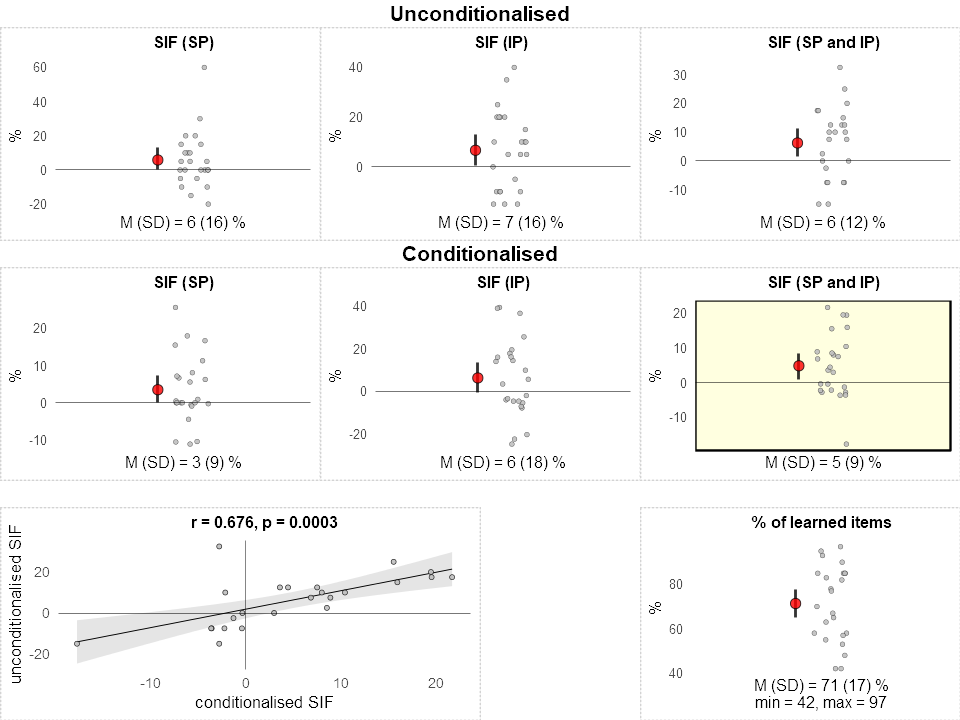

In [10]:
# Plot results
# ----------------------------------------------------------------------
options(repr.plot.width = 8, repr.plot.height = 6) 

# 1. Unconditionalised SP SIF
p12 <- plotResults(dataTNT, dataTNT$spSIFuc, 1, "SIF (SP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spSIFuc"], dscrTNT["std.dev","spSIFuc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 2. Unconditionalised IP SIF
p13 <- plotResults(dataTNT, dataTNT$ipSIFuc, 1, "SIF (IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","ipSIFuc"], dscrTNT["std.dev","ipSIFuc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 3. Unconditionalised SPIP SIF SP and IP
p14 <- plotResults(dataTNT, dataTNT$spipSIFuc, 1, "SIF (SP and IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spipSIFuc"], dscrTNT["std.dev","spipSIFuc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 4. Conditionalised SP SIF
p15 <- plotResults(dataTNT, dataTNT$spSIFc, 1, "SIF (SP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spSIFc"], dscrTNT["std.dev","spSIFc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 5. Conditionalised IP SIF
p16 <- plotResults(dataTNT, dataTNT$ipSIFc, 1, "SIF (IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","ipSIFc"], dscrTNT["std.dev","ipSIFc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 6. Conditionalised SIF SP and IP
p17 <- plotResults(dataTNT, dataTNT$spipSIFc, 1, "SIF (SP and IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spipSIFc"], dscrTNT["std.dev","spipSIFc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1) + theme(
  panel.background = element_rect(fill = "lightyellow"))

# 7. Relationship between conditionalised and unconditionalised SIFs
corr.SIF <- rcorr(dataTNT$spipSIFuc, dataTNT$spipSIFc)
resTxt  <- sprintf("r = %.3f, p = %.4f", corr.SIF$r[2], corr.SIF$P[2])
p18 <- plotCorrelation(dataTNT, dataTNT$spipSIFc, dataTNT$spipSIFuc, 
                           "conditionalised SIF", "unconditionalised SIF", resTxt, 1, 10) + 
    geom_vline(aes(xintercept = 0), size = 0.1) + geom_hline(aes(yintercept = 0), size = 0.1)
           

# 8. % of learned (included in analysis) items
p19 <- plotResults(dataTNT, dataTNT$criterion, 1, "% of learned items", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%\nmin = %.0f, max = %.0f", 
                           dscrTNT["mean","criterion"], dscrTNT["std.dev","criterion"], 
                           dscrTNT["min","criterion"], dscrTNT["max","criterion"])) + 
      scale_x_discrete()

## Put all plots in a grid and display
grid.arrange(arrangeGrob(p12, p13, p14, 
                         top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(p15, p16, p17, 
                         top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1),
             arrangeGrob(p18, p19, 
                         top="", layout_matrix = rbind(c(1,1,1,NA,2,2))))

### SIF effect (conditionalised, SP and IP)

In [11]:
# SIF effect (conditionalised, SP and IP)
# ----------------------------------------------------------------------
# http://www.sthda.com/english/wiki/one-sample-t-test-in-r
# Since the sample size is not large enough (less than 30, central limit theorem), we need to check whether 
# the data follow a normal distribution.
# It's possible to use the Shapiro-Wilk normality test and to look at the normality plot.
# 
# Shapiro-Wilk test:
#   Null hypothesis: the data are normally distributed
# Alternative hypothesis: the data are not normally distributed
shapiro.test(dataTNT$spipSIFc)

# SIF data are normally  distributed! Can do t.test. Otherwise would need to to wilcox.test
t.SIFc <- t.test(dataTNT$spipSIFc, mu = 0, alternative = "greater")
t.SIFc
sprintf("SIF effect: t(%d) = %.2f, p = %.3f, d = %.3f", 
        t.SIFc$parameter, t.SIFc$statistic, t.SIFc$p.value, t.SIFc$statistic/sqrt(t.SIFc$parameter+1))



	Shapiro-Wilk normality test

data:  dataTNT$spipSIFc
W = 0.94945, p-value = 0.2636



	One Sample t-test

data:  dataTNT$spipSIFc
t = 2.5519, df = 23, p-value = 0.008912
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 1.592493      Inf
sample estimates:
mean of x 
 4.849436 


[1] "SIF effect: t(23) = 2.55, p = 0.009, d = 0.521"

## SSRT and SIF outliers
To identify univariate and bi-variate outliers in the SSRT and SIF scores, we used box plot method, which relies on the interquartile range. Univariate outliers were not present for any of the two measures. One bi-variate outlier was removed from the correlation analysis and the behavioural partial least squares analysis (described below). Nevertheless, outlier removal did not qualitatively alter the results.

In [12]:
# ==================================================================
# SSRT and SIF OUTLIERS
# ==================================================================
SSRT <- dataSSTsubj$SSRT
SIF  <- dataTNT$spSIFc

layout(matrix(c(1,2,3), ncol = 3, byrow = TRUE))
options(repr.plot.width = 8, repr.plot.height = 3) # change plot size

get_outliers <- function(SIFvar, SIFtype, SS, SStype, disp) { # SS: a measure from SS task (e.g., SSRT or TF)
  par(mfrow=c(1,3)) 
  # Univariate, boxplot method
  # ------------------------------------
  bpSS <- boxplot(SS, main = SStype, ylab = 'ms', ylim = rev(range(SS)), plot = disp) 
  bpSIF  <- boxplot(SIFvar, main = paste(SIFtype, "SIF"), ylab = '%', plot = disp)
  
  # oSS
  ifelse(is.null(bpSS$out), oSS <- vector(mode="numeric", length=0),  oSS <- which(SS == bpSS$out))
  # oSIF
  ifelse(is.null(bpSIF$out), oSIF <- vector(mode="numeric", length=0),  oSIF <- which(SIFvar == bpSIF$out))
  
  # Bi-variate, bogplot method
  # ------------------------------------
  # A bagplot is a bivariate generalization of the  boxplot. A bivariate boxplot. 
  bpl  <- compute.bagplot(SS, SIFvar)
  # oBiv
  ifelse(is.null(bpl$pxy.outlier), oBiv <- vector(mode="numeric", length=0), 
         oBiv <- which(SS %in% bpl$pxy.outlier[,1]))
  bpSSSIF <- bagplot(SIFvar, SS, cex = 2, ylim = rev(range(SS)), 
                     ylab = SStype, xlab = paste(SIFtype, 'SIF (%)'), main = 'bi-variate', create.plot = disp)
  # Report results
  # ------------------------------------
  oSSres <- c(sprintf(paste(SStype, "outliers: %d"), length(bpSS$out)),
  if(length(bpSS$out) > 0) {print(data.frame(SS,SIFvar)[oSS, ])})
  
  oSIFres <- c(sprintf("SIF outliers: %d", length(bpSIF$out)),
  if(length(bpSIF$out) > 0) {print(data.frame(SS,SIFvar)[oSIF, ])})
  
  oBivres <- c(sprintf("Bi-variate outliers: %d", length(oBiv)),
  if(length(oBiv) > 0) {print(data.frame(SS,SIFvar)[oBiv, ])})
  
  outl <- c(oSS, oSIF, oBiv)
  
  return(list(outl, c(oSSres, oSIFres, oBivres)))
}

### Outliers with Unconditionalised SIF

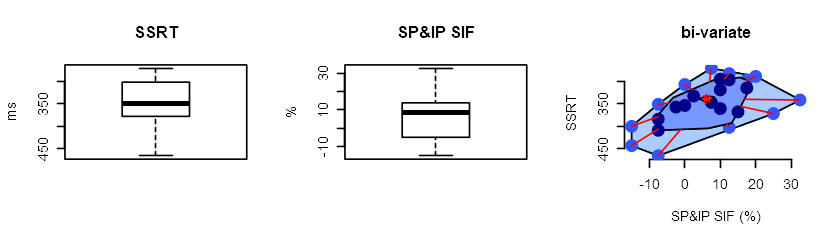

         SS SIFvar
16 341.4553     60
         SS SIFvar
16 341.4553     60


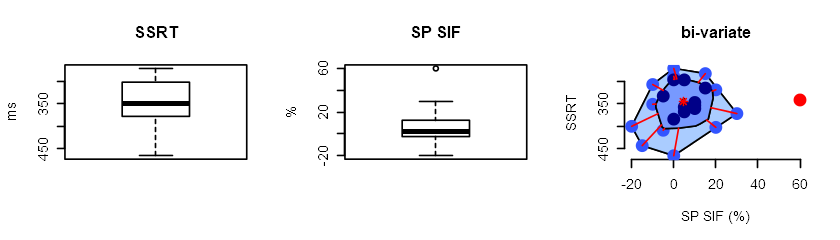

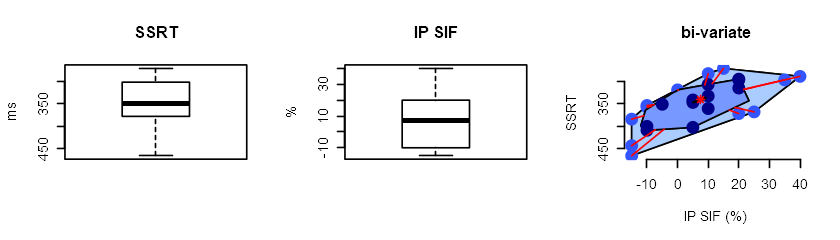

In [13]:
options(repr.plot.width = 7, repr.plot.height = 2) # change plot size
u_spipOutliers <- get_outliers(dataTNT$spipSIFu, "SP&IP", SSRT, "SSRT", disp = TRUE)
u_spOutliers   <- get_outliers(dataTNT$spSIFu, "SP", SSRT, "SSRT", disp = TRUE)
u_ipOutliers   <- get_outliers(dataTNT$ipSIFu, "IP", SSRT, "SSRT", disp = TRUE)

### Outliers with Conditionalised SIF

        SS    SIFvar
9 443.1415 -17.70833


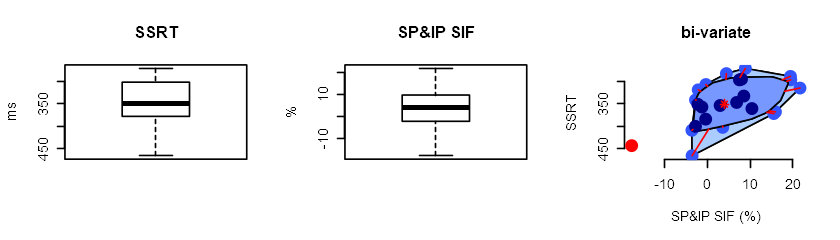

         SS   SIFvar
23 360.5882 25.59524


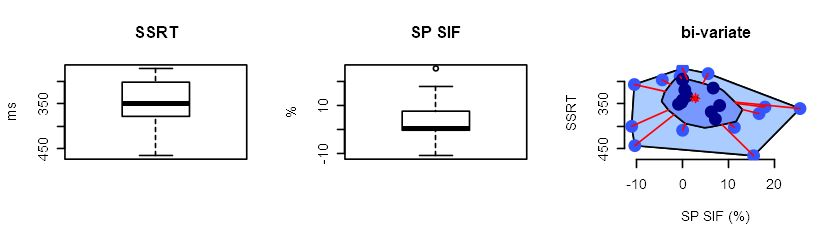

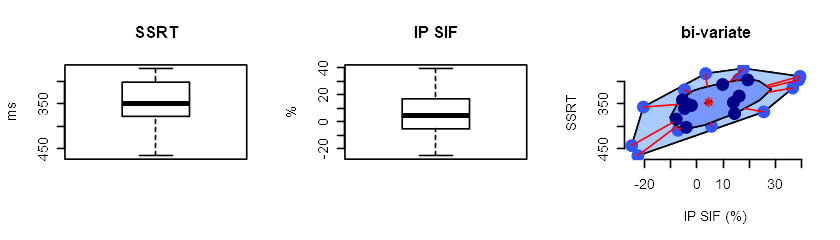

In [14]:
options(repr.plot.width = 7, repr.plot.height = 2) # change plot size
c_spipOutliers <- get_outliers(dataTNT$spipSIFc, "SP&IP", SSRT, "SSRT", disp = TRUE)
c_spOutliers   <- get_outliers(dataTNT$spSIFc, "SP", SSRT, "SSRT", disp = TRUE)
c_ipOutliers   <- get_outliers(dataTNT$ipSIFc, "IP", SSRT, "SSRT", disp = TRUE)

## SSRT and SIF correlation

In [15]:
# ==================================================================
# SSRT and SIF CORRELATION
# ==================================================================
sNR <- dataTNT$sNR

# With outliers
# ----------------------------------------------------------------------
corplot_wo <- function(SIFvar, SIFtype) {
  res.tmp <- data.frame(sNR, SSRT, SIF = SIFvar)
  corr.SSRT.SIF    <- rcorr(res.tmp$SIF, res.tmp$SSRT)
  corrRob.SSRT.SIF <- covRob(cbind(res.tmp$SIF, res.tmp$SSRT),
                             corr = TRUE,
                             estim = "auto")
  resTxt  <- sprintf(
    "r = %.3f, p = %.4f\nr(robust) = %.3f",
    corr.SSRT.SIF$r[2],
    corr.SSRT.SIF$P[2],
    corrRob.SSRT.SIF$cov[2]
  )
  plotCorrelation(res.tmp,
                  res.tmp$SIF,
                  res.tmp$SSRT,
                  paste("Inhibiting memories (", SIFtype, "SIF, %)"),
                  "Inhibiting actions (SSRT, ms)",
                  resTxt, 1.8, 11
  ) +
    scale_y_reverse() + geom_vline(aes(xintercept = 0), size = 0.1)
}

# Without outliers
# ----------------------------------------------------------------------
corplot_no <- function(SIFvar, SIFtype, outl) {
  res.tmp <- data.frame(sNR, SSRT, SIF = SIFvar)
  #outliers <- get_outliers(SIFvar, SIFtype, SSRT, "SSRT")
  res.tmp <- subset(res.tmp, !(sNR %in% outl))

  corr.SSRT.SIF    <- rcorr(res.tmp$SIF, res.tmp$SSRT)
  corrRob.SSRT.SIF <- covRob(cbind(res.tmp$SIF, res.tmp$SSRT),
                             corr = TRUE,
                             estim = "auto")
  resTxt  <- sprintf(
    "r = %.3f, p = %.4f\nr(robust) = %.3f",
    corr.SSRT.SIF$r[2],
    corr.SSRT.SIF$P[2],
    corrRob.SSRT.SIF$cov[2]
  )
  plotCorrelation(res.tmp,
                  res.tmp$SIF,
                  res.tmp$SSRT,
                  paste("Inhibiting memories (", SIFtype, "SIF, %)"),
                  "Inhibiting actions (SSRT, ms)",
                  resTxt, 1.8, 11
  ) +
    scale_y_reverse() + geom_vline(aes(xintercept = 0), size = 0.1)
}

### Including outliers

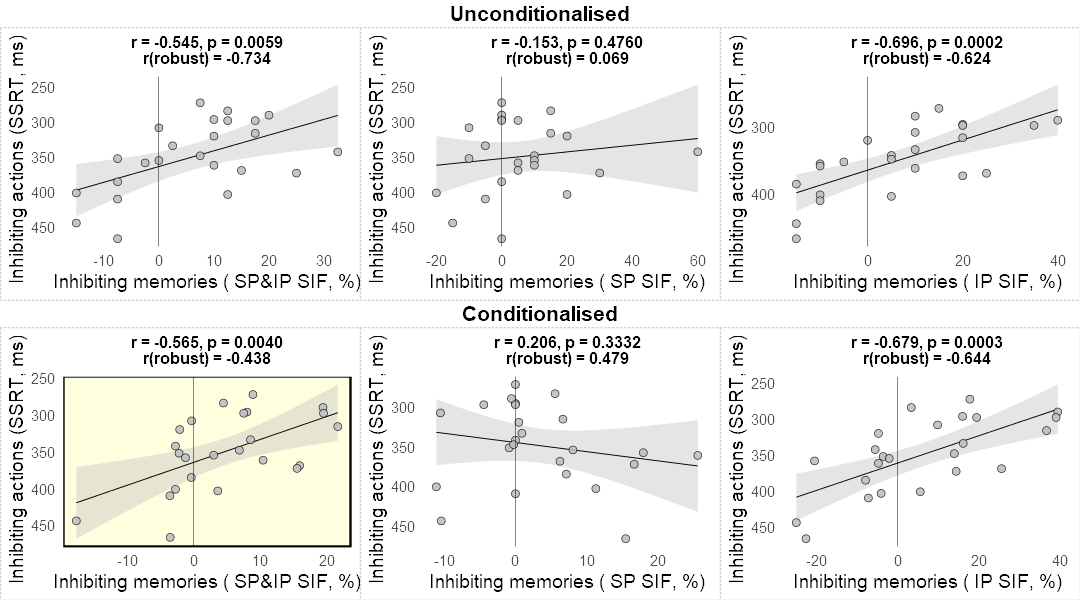

In [16]:
# plot all
options(repr.plot.width = 9, repr.plot.height = 5) # change plot size
grid.arrange(arrangeGrob(corplot_wo(dataTNT$spipSIFu, "SP&IP"), 
                         corplot_wo(dataTNT$spSIFu, "SP"), 
                         corplot_wo(dataTNT$ipSIFu, "IP"), 
                         top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(corplot_wo(dataTNT$spipSIFc, "SP&IP") + 
                            theme(panel.background = element_rect(fill = "lightyellow")), 
                         corplot_wo(dataTNT$spSIFc, "SP"), 
                         corplot_wo(dataTNT$ipSIFc, "IP"), 
                         top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1))

### Excluding outliers

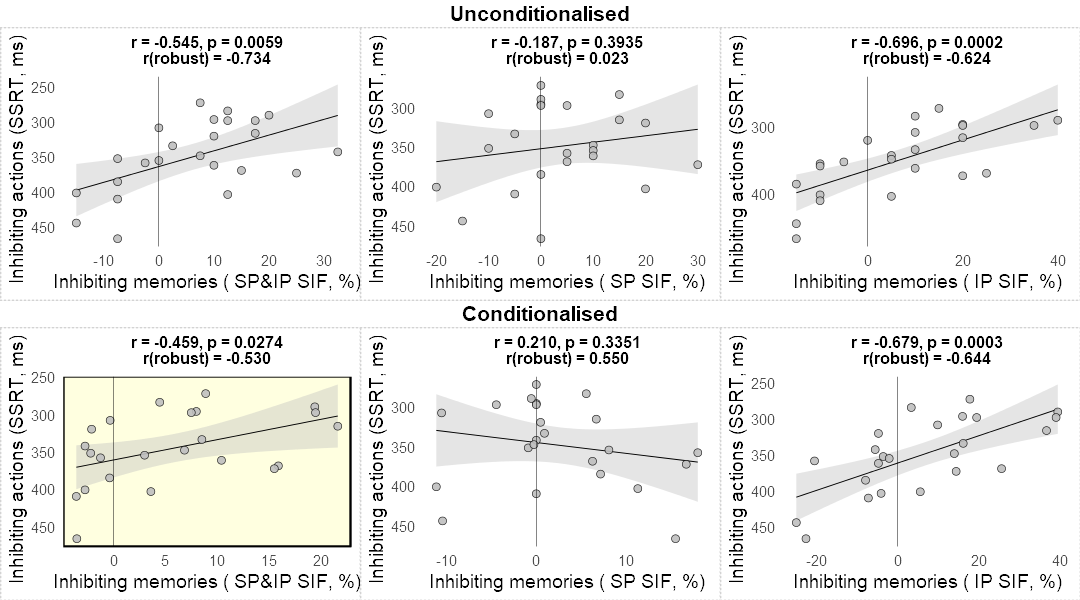

In [17]:
# plot all
options(repr.plot.width = 9, repr.plot.height = 5) # change plot size
grid.arrange(arrangeGrob(corplot_no(dataTNT$spipSIFu, "SP&IP", u_spipOutliers[[1]]), 
                         corplot_no(dataTNT$spSIFu, "SP", u_spOutliers[[1]]), 
                         corplot_no(dataTNT$ipSIFu, "IP", u_ipOutliers[[1]]), 
                         top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(corplot_no(dataTNT$spipSIFc, "SP&IP", c_spipOutliers[[1]]) + 
                            theme(panel.background = element_rect(fill = "lightyellow")), 
                         corplot_no(dataTNT$spSIFc, "SP", c_spOutliers[[1]]), 
                         corplot_no(dataTNT$ipSIFc, "IP", c_ipOutliers[[1]]), 
                         top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1))

## SSRTs accounting for Stop Trigger Failures

In [18]:
# ==================================================================
# SSRT with Trigger Failures
# ==================================================================
# Descriptives
# ----------------------------------------------------------------------
dscr_tfSSRT <-
  stat.desc(data_tfSSRT,
            basic = TRUE,
            desc = TRUE,
            p = 0.95)
print(round(dscr_tfSSRT, 2))

tfSSRT <- data_tfSSRT$tfSSRT
tf     <- data_tfSSRT$p_tf

                sID  tfSSRT  p_tf
nbr.val       24.00   24.00 24.00
nbr.null       0.00    0.00  0.00
nbr.na         0.00    0.00  0.00
min            1.00  208.82  0.12
max           24.00  341.18  0.46
range         23.00  132.35  0.34
sum          300.00 6692.16  6.06
median        12.50  279.01  0.24
mean          12.50  278.84  0.25
SE.mean        1.44    8.40  0.02
CI.mean.0.95   2.99   17.37  0.04
var           50.00 1691.84  0.01
std.dev        7.07   41.13  0.09
coef.var       0.57    0.15  0.34


### Outliers
#### Outliers with Unconditionalised SIF

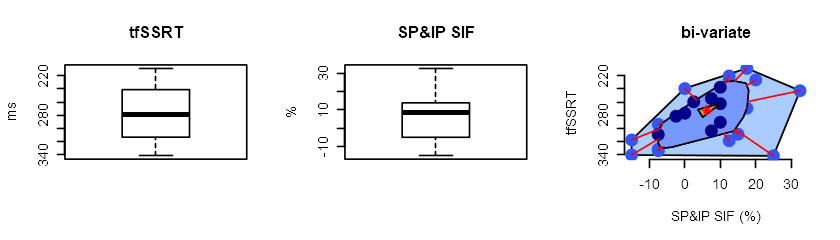

         SS SIFvar
16 242.6404     60
         SS SIFvar
16 242.6404     60


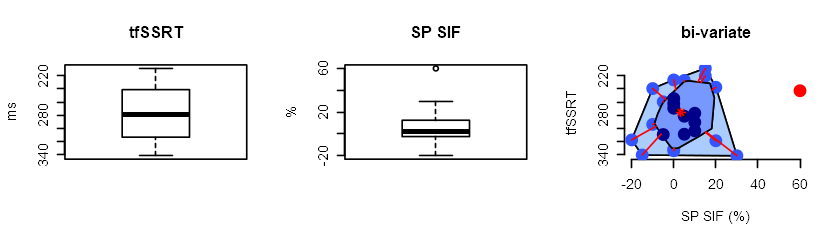

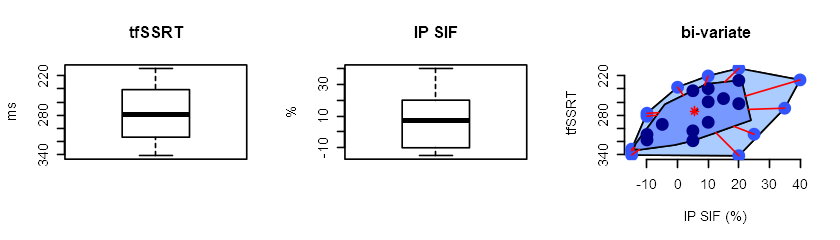

In [19]:
options(repr.plot.width = 7, repr.plot.height = 2) # change plot size
u_spipOutl_tfSSRT <- get_outliers(dataTNT$spipSIFu, "SP&IP", tfSSRT, "tfSSRT", disp = TRUE)
u_spOutl_tfSSRT   <- get_outliers(dataTNT$spSIFu, "SP", tfSSRT, "tfSSRT", disp = TRUE)
u_ipOutl_tfSSRT   <- get_outliers(dataTNT$ipSIFu, "IP", tfSSRT, "tfSSRT", disp = TRUE)

#### Outliers with Conditionalised SIF

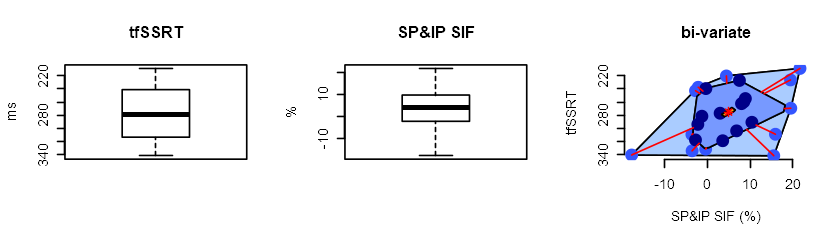

         SS   SIFvar
23 290.4739 25.59524
        SS    SIFvar
6 317.1974 -11.11111
9 340.0553 -10.41667


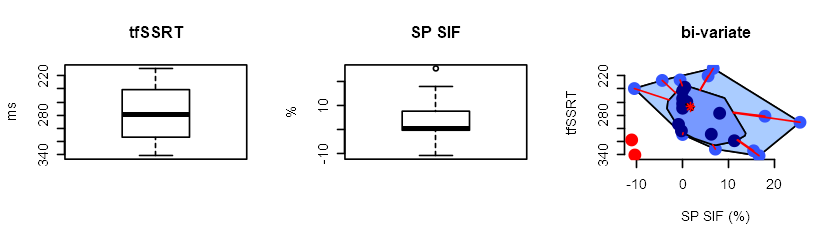

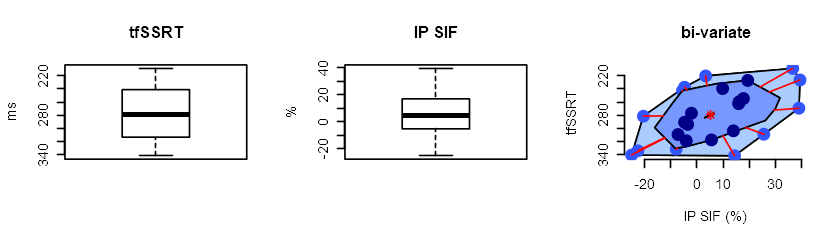

In [20]:
options(repr.plot.width = 7, repr.plot.height = 2) # change plot size
c_spipOutl_tfSSRT <- get_outliers(dataTNT$spipSIFc, "SP&IP", tfSSRT, "tfSSRT", disp = TRUE)
c_spOutl_tfSSRT   <- get_outliers(dataTNT$spSIFc, "SP", tfSSRT, "tfSSRT", disp = TRUE)
c_ipOutl_tfSSRT   <- get_outliers(dataTNT$ipSIFc, "IP", tfSSRT, "tfSSRT", disp = TRUE)

### tfSSRT and SIF correlation

In [21]:
# tfSSRT and SIF CORRELATION
# ----------------------------------------------------------------------
# With outliers
# ----------------------------------------------------------------------
corplot2_wo <- function(SIFvar, SIFtype) {
  res.tmp <- data.frame(tfSSRT, SIF = SIFvar)
  corr.SSRT.SIF    <- rcorr(res.tmp$SIF, res.tmp$tfSSRT)
  corrRob.SSRT.SIF <- covRob(cbind(res.tmp$SIF, res.tmp$tfSSRT),
           corr = TRUE,
           estim = "auto")
  resTxt  <- sprintf(
    "r = %.3f, p = %.3f\nr(robust) = %.3f",
    corr.SSRT.SIF$r[2],
    corr.SSRT.SIF$P[2],
    corrRob.SSRT.SIF$cov[2]
  )
  plotCorrelation(res.tmp,
    res.tmp$SIF,
    res.tmp$tfSSRT,
    paste("Inhibiting memories (", SIFtype, "SIF, %)"),
    "Inhibiting actions (SSRT, ms)",
    resTxt, 1.8, 11
  ) +
    scale_y_reverse() + geom_vline(aes(xintercept = 0), size = 0.1)
}

# Without outliers
# ----------------------------------------------------------------------
corplot2_no <- function(SIFvar, SIFtype, outl) {
  res.tmp <- data.frame(sNR, tfSSRT, SIF = SIFvar)
  res.tmp <- subset(res.tmp, !(sNR %in% outl))
  
  corr.SSRT.SIF    <- rcorr(res.tmp$SIF, res.tmp$tfSSRT)
  corrRob.SSRT.SIF <- covRob(cbind(res.tmp$SIF, res.tmp$tfSSRT),
                             corr = TRUE,
                             estim = "auto")
  resTxt  <- sprintf(
    "r = %.3f, p = %.3f\nr(robust) = %.3f",
    corr.SSRT.SIF$r[2],
    corr.SSRT.SIF$P[2],
    corrRob.SSRT.SIF$cov[2]
  )
  plotCorrelation(res.tmp,
                  res.tmp$SIF,
                  res.tmp$tfSSRT,
                  paste("Inhibiting memories (", SIFtype, "SIF, %)"),
                  "Inhibiting actions (SSRT, ms)",
                  resTxt, 1.8, 11
  ) +
    scale_y_reverse() + geom_vline(aes(xintercept = 0), size = 0.1)
}

#### Including outliers

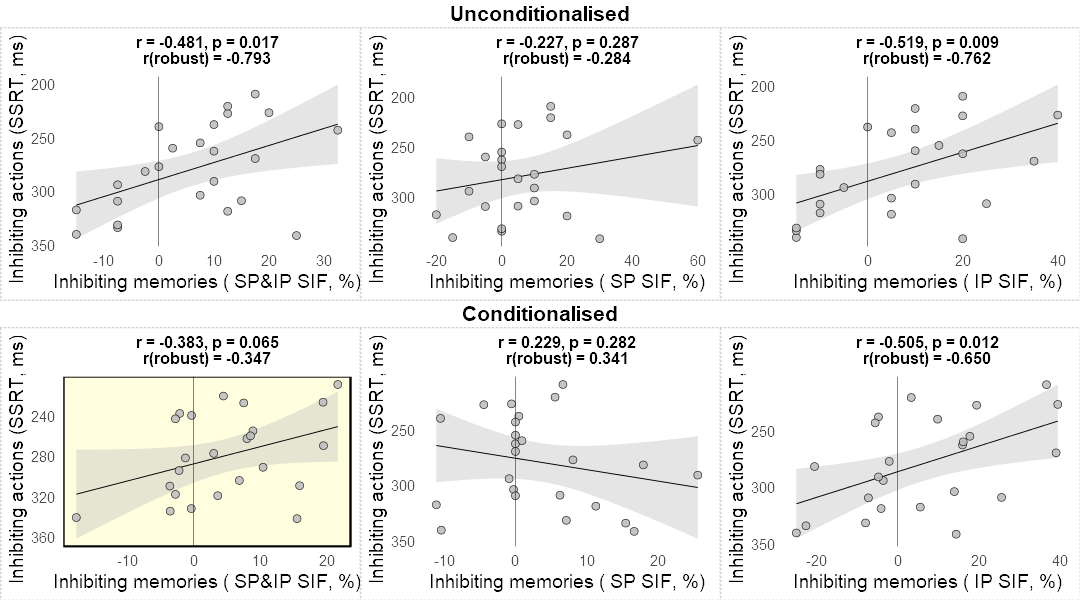

In [22]:
# plot all
options(repr.plot.width = 9, repr.plot.height = 5) # change plot size
grid.arrange(arrangeGrob(corplot2_wo(dataTNT$spipSIFu, "SP&IP"), 
                         corplot2_wo(dataTNT$spSIFu, "SP"), 
                         corplot2_wo(dataTNT$ipSIFu, "IP"), 
                         top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(corplot2_wo(dataTNT$spipSIFc, "SP&IP") + 
                            theme(panel.background = element_rect(fill = "lightyellow")), 
                         corplot2_wo(dataTNT$spSIFc, "SP"), 
                         corplot2_wo(dataTNT$ipSIFc, "IP"), 
                         top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1))

#### Excluding outliers

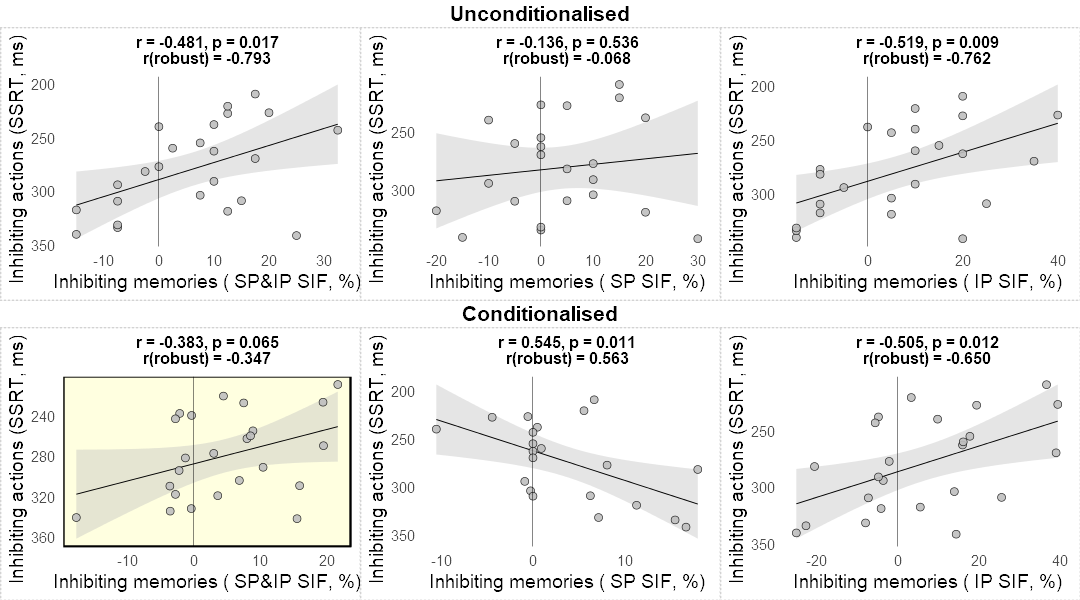

In [23]:
# plot all
options(repr.plot.width = 9, repr.plot.height = 5) # change plot size
grid.arrange(arrangeGrob(corplot2_no(dataTNT$spipSIFu, "SP&IP", u_spipOutl_tfSSRT[[1]]), 
                         corplot2_no(dataTNT$spSIFu, "SP", u_spOutl_tfSSRT[[1]]), 
                         corplot2_no(dataTNT$ipSIFu, "IP", u_ipOutl_tfSSRT[[1]]), 
                         top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(corplot2_no(dataTNT$spipSIFc, "SP&IP", c_spipOutl_tfSSRT[[1]]) + 
                             theme(panel.background = element_rect(fill = "lightyellow")), 
                         corplot2_no(dataTNT$spSIFc, "SP", c_spOutl_tfSSRT[[1]]), 
                         corplot2_no(dataTNT$ipSIFc, "IP", c_ipOutl_tfSSRT[[1]]), 
                         top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1))

## Trigger Failure and SIF correlation

### Outliers
#### Ouliers with Unconditionalised SIF

       SS SIFvar
16 0.3079   32.5


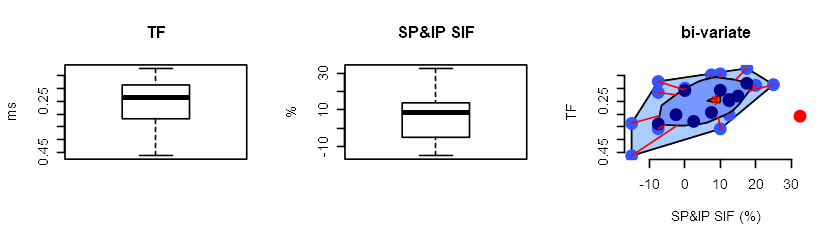

       SS SIFvar
16 0.3079     60
       SS SIFvar
12 0.1843     30
16 0.3079     60


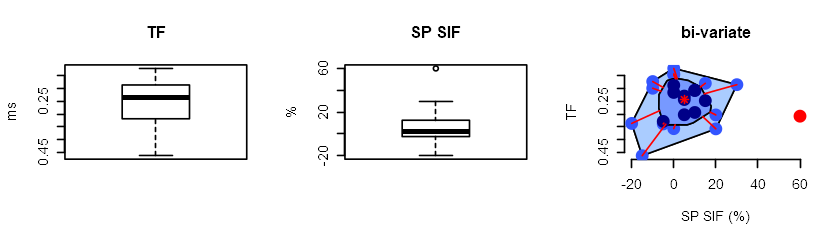

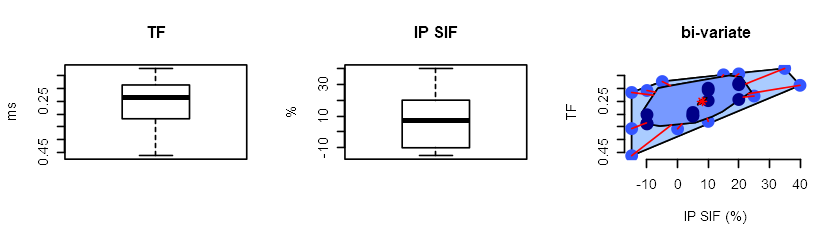

In [24]:
options(repr.plot.width = 7, repr.plot.height = 2) # change plot size
u_spipOutl_tf <- get_outliers(dataTNT$spipSIFu, "SP&IP", tf, "TF", disp = TRUE)
u_spOutl_tf   <- get_outliers(dataTNT$spSIFu, "SP", tf, "TF", disp = TRUE)
u_ipOutl_tf   <- get_outliers(dataTNT$ipSIFu, "IP", tf, "TF", disp = TRUE)

#### Outliers with Conditionalised SIF

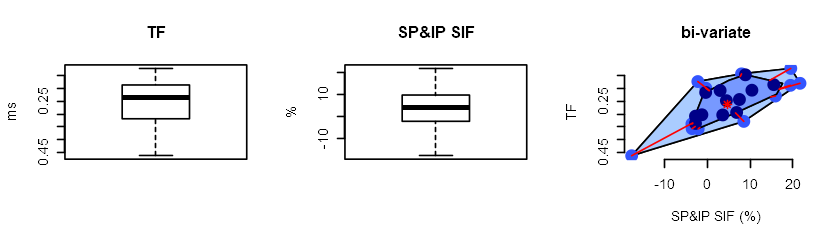

       SS   SIFvar
23 0.2061 25.59524
       SS   SIFvar
23 0.2061 25.59524


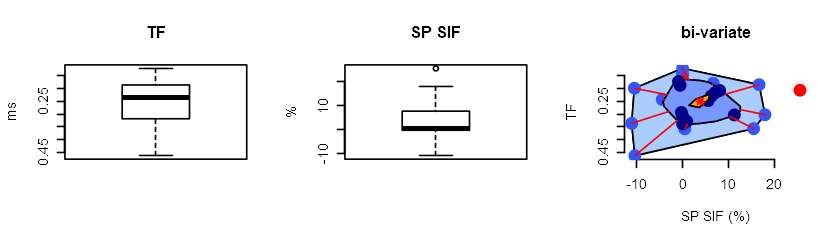

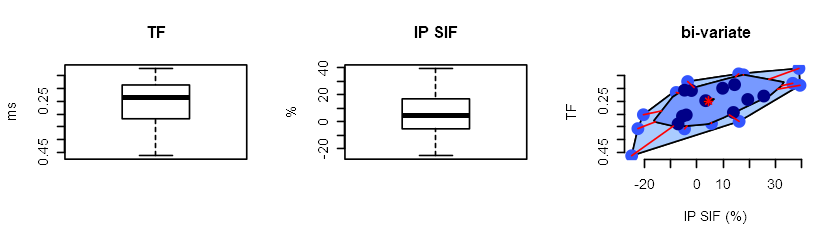

In [25]:
options(repr.plot.width = 7, repr.plot.height = 2) # change plot size
c_spipOutl_tf <- get_outliers(dataTNT$spipSIFc, "SP&IP", tf, "TF", disp = TRUE)
c_spOutl_tf   <- get_outliers(dataTNT$spSIFc, "SP", tf, "TF", disp = TRUE)
c_ipOutl_tf   <- get_outliers(dataTNT$ipSIFc, "IP", tf, "TF", disp = TRUE)

In [26]:
# TF and SIF CORRELATION
# ----------------------------------------------------------------------
# With outliers
# ----------------------------------------------------------------------
corplot3_wo <- function(SIFvar, SIFtype) {
  res.tmp <- data.frame(tf, SIF = SIFvar)
  corr.TF.SIF      <- rcorr(res.tmp$SIF, res.tmp$tf)
  corrRob.SSRT.SIF <- covRob(cbind(res.tmp$SIF, res.tmp$tf),
                             corr = TRUE,
                             estim = "auto")
  resTxt  <- sprintf(
    "r = %.3f, p = %.4f\nr(robust) = %.3f",
    corr.TF.SIF$r[2],
    corr.TF.SIF$P[2],
    corrRob.SSRT.SIF$cov[2]
  )
  plotCorrelation(res.tmp,
                  res.tmp$SIF,
                  res.tmp$tf,
                  paste("Inhibiting memories (", SIFtype, "SIF, %)"),
                  "Stop trigger failures (p)",
                  resTxt, 1.8, 11
  ) +
    geom_vline(aes(xintercept = 0), size = 0.1)
}

# Without outliers
# ----------------------------------------------------------------------
corplot3_no <- function(SIFvar, SIFtype, outl) {
  res.tmp <- data.frame(sNR, tf, SIF = SIFvar)
  res.tmp <- subset(res.tmp, !(sNR %in% outl))
  
  corr.TF.SIF      <- rcorr(res.tmp$SIF, res.tmp$tf)
  corrRob.SSRT.SIF <- covRob(cbind(res.tmp$SIF, res.tmp$tf),
                             corr = TRUE,
                             estim = "auto")
  resTxt  <- sprintf(
    "r = %.3f, p = %.4f\nr(robust) = %.3f",
    corr.TF.SIF$r[2],
    corr.TF.SIF$P[2],
    corrRob.SSRT.SIF$cov[2]
  )
  plotCorrelation(res.tmp,
                  res.tmp$SIF,
                  res.tmp$tf,
                  paste("Inhibiting memories (", SIFtype, "SIF, %)"),
                  "Stop trigger failures (p)",
                  resTxt, 1.8, 11
  ) +
    geom_vline(aes(xintercept = 0), size = 0.1)
}

### Including outliers

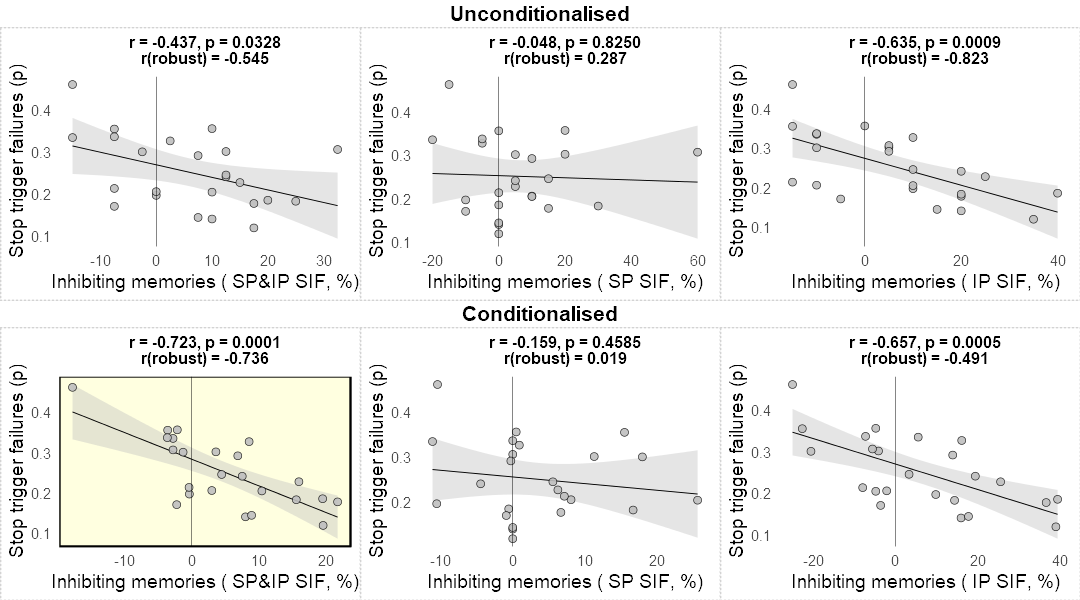

In [27]:
# plot all
options(repr.plot.width = 9, repr.plot.height = 5) # change plot size
grid.arrange(arrangeGrob(corplot3_wo(dataTNT$spipSIFu, "SP&IP"), 
                         corplot3_wo(dataTNT$spSIFu, "SP"), 
                         corplot3_wo(dataTNT$ipSIFu, "IP"), 
                         top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(corplot3_wo(dataTNT$spipSIFc, "SP&IP") + 
                            theme(panel.background = element_rect(fill = "lightyellow")), 
                         corplot3_wo(dataTNT$spSIFc, "SP"), 
                         corplot3_wo(dataTNT$ipSIFc, "IP"), 
                         top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1))

### Excluding outliers

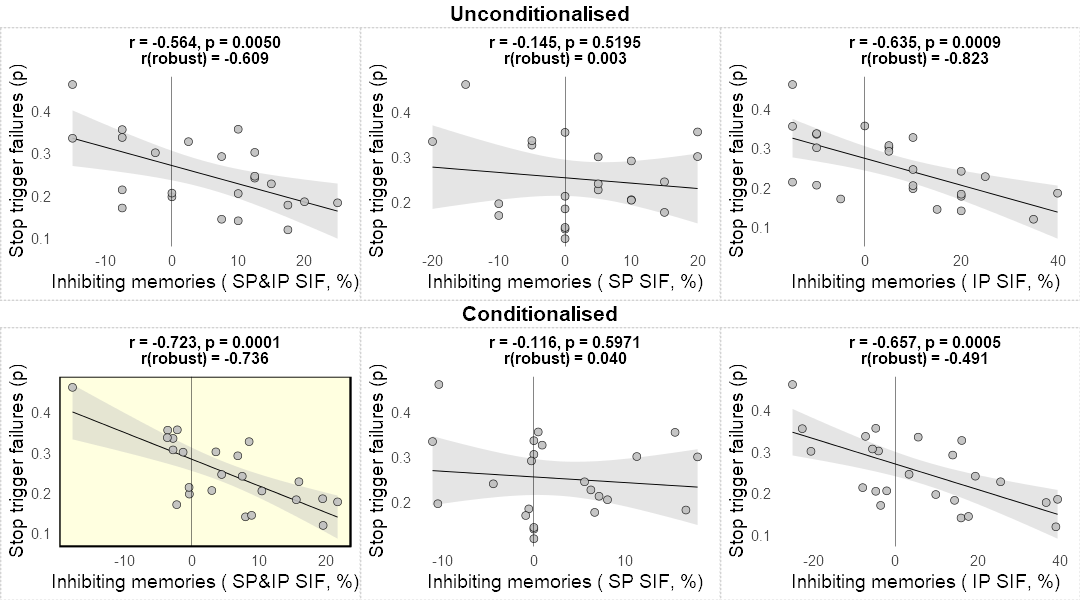

In [28]:
# plot all
options(repr.plot.width = 9, repr.plot.height = 5) # change plot size
grid.arrange(arrangeGrob(corplot3_no(dataTNT$spipSIFu, "SP&IP", u_spipOutl_tf[[1]]), 
                         corplot3_no(dataTNT$spSIFu, "SP", u_spOutl_tf[[1]]), 
                         corplot3_no(dataTNT$ipSIFu, "IP", u_ipOutl_tf[[1]]), 
                         top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(corplot3_no(dataTNT$spipSIFc, "SP&IP", c_spipOutl_tf[[1]])  + 
                             theme(panel.background = element_rect(fill = "lightyellow")), 
                         corplot3_no(dataTNT$spSIFc, "SP", c_spOutl_tf[[1]]), 
                         corplot3_no(dataTNT$ipSIFc, "IP", c_ipOutl_tf[[1]]), 
                         top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1))

# ROI analysis: inhibitory targets, hippocampus and M1

In [43]:
library(ggplot2)   # for plotting results
library(tidyr)     # for creating long table (function gather)
library(Rmisc)     # for getting summary data frame
library(gridExtra) # for adding plots together
library(grid)      # for plot grid title formatting
library(plyr)      # for changing factor level names
library(gtools)    # for converting pvalues to stars
# ----------------------------------------------------------------------
# GET THE DATA
# ----------------------------------------------------------------------
data <-
  read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/targetROIs_psc.csv')
dataLong <- gather(data, seconds, psc, X0s:X10s, factor_key = TRUE)

dataLong$inhibit <-
  as.factor(ifelse((
    dataLong$condition == 's' | dataLong$condition == 'nt'
  ), 1, 0))

# subsets
dataLong.rHCTNT <-
  subset(dataLong, roi == 'rHC' &
           (condition == 't' | condition == 'nt'))
dataLong.rHCSG <-
  subset(dataLong, roi == 'rHC' &
           (condition == 'g' | condition == 's'))

dataLong.lM1TNT <-
  subset(dataLong, roi == 'lM1' &
           (condition == 't' | condition == 'nt'))
dataLong.lM1SG <-
  subset(dataLong, roi == 'lM1' &
           (condition == 'g' | condition == 's'))

# ----------------------------------------------------------------------
# ROI x MODALITY INTERACTION
# ----------------------------------------------------------------------
dataInh <- subset(data, (condition == 'nt' | condition == 's'))
dataExp <- subset(data, (condition == 't' | condition == 'g'))

#substract Express from Inhibit
dataModality <- cbind(dataInh[, 1:3], dataInh[, 4:9] - dataExp[, 4:9])

dataModality$condition <- as.factor(dataModality$condition)
# Change conditions to the corresponding Modality
dataModality$condition <-
  revalue(dataModality$condition, c("nt" = "nt_t", "s" = "s_g"))
names(dataModality)[names(dataModality) == 'condition'] <-
  'modality'

# Average PSC within a timespan of 2-6s, as in Levy&Anderson, 2012
dataModality$PSC <- rowMeans(dataModality[, 5:8])

# plot the interaction
p1 <-
  ggplot(data = dataModality, aes(
    x = roi,
    color = modality,
    group = modality,
    y = PSC
  )) +
  geom_hline(aes(yintercept = 0), size = 0.2) +
  stat_summary(fun.y = mean, geom = "line", size = 2) +
  stat_summary(
    fun.data = mean_se,
    geom = "pointrange",
    aes(color = modality, fill = modality),
    size = 2,
    show.legend = FALSE
  ) +
  scale_color_manual(
    labels = c("No-Think - Think", "Stop - Go"),
    values = c('red', '#ffc000')
  ) +
  scale_fill_manual(values = c('red', '#ffc000')) +
  guides(color = guide_legend("")) +
  scale_x_discrete(limits = c("rHC", "lM1"),
                   labels = c("Hippocampus", "M1")) +
  labs(x = "Target region", y = "% signal change difference") +
  ggtitle("Target region x Modality interaction") +
  theme_minimal() +
  theme(
    text = element_text(size = 20),
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position = "top"
  )

# statistics
summary.anova <-
  summary(res.anova <-
            aov(PSC ~ roi * modality + Error(sid / (roi * modality)), data = dataModality))
res.txt.anova <- sprintf(
  'F(%d,%d) = %.2f, p = %.7f',
  summary.anova[["Error: sid:roi:modality"]][[1]][["Df"]][1],
  summary.anova[["Error: sid:roi:modality"]][[1]][["Df"]][2],
  summary.anova[["Error: sid:roi:modality"]][[1]][["F value"]][1],
  summary.anova[["Error: sid:roi:modality"]][[1]][["Pr(>F)"]][1]
)

# paired t-test of HC vs M1 for NTT
data.ntt.rHC  <- subset(dataModality, roi == 'rHC' & modality == 'nt_t')
data.ntt.lM1  <- subset(dataModality, roi == 'lM1' & modality == 'nt_t')
res.ntt <- t.test(
    data.ntt.rHC$PSC,
    data.ntt.lM1$PSC,
    alternative = c("two.sided"),
    paired = TRUE
  )
res.txt.ntt <- sprintf(
  't(%d) = %.2f, p = %.3f, d = %.3f',
  res.ntt[["parameter"]][["df"]],
  abs(res.ntt[["statistic"]][["t"]]),
  res.ntt[["p.value"]],
  abs(res.ntt[["statistic"]][["t"]] / sqrt(res.ntt[["parameter"]][["df"]] + 1))
)

# paired t-test of HC vs M1 for SG
data.sg.rHC <- subset(dataModality, roi == 'rHC' & modality == 's_g')
data.sg.lM1  <- subset(dataModality, roi == 'lM1' & modality == 's_g')
res.sg <-
  t.test(
    data.sg.rHC$PSC,
    data.sg.lM1$PSC,
    alternative = c("two.sided"),
    paired = TRUE
  )
res.txt.sg <- sprintf(
    't(%d) = %.2f, p = %.7f, d = %.3f',
    res.sg[["parameter"]][["df"]],
    abs(res.sg[["statistic"]][["t"]]),
    res.sg[["p.value"]], 
    abs(res.sg[["statistic"]][["t"]]/sqrt(res.sg[["parameter"]][["df"]] + 1))
)

# add p value stars to the plot
p1 <- p1 +
  annotate(
    "text",
    x = 1.5,
    y = mean(dataModality$PSC) + sd(dataModality$PSC),
    label = stars.pval(summary.anova[["Error: sid:roi:modality"]][[1]][["Pr(>F)"]][1]),
    size = 10
  ) +
  annotate(
    "text",
    x = 1.38,
    y = mean(c(mean(data.ntt.rHC$PSC), mean(data.ntt.lM1$PSC))),
    label = stars.pval(res.ntt[["p.value"]]),
    color = "red",
    size = 10
  ) +
  annotate(
    "text",
    x = 1.65,
    y = mean(c(mean(data.sg.rHC$PSC), mean(data.sg.lM1$PSC))),
    label = stars.pval(res.sg[["p.value"]]),
    color = "#ffc000",
    size = 10
  )

## Target region x Modality interaction plot

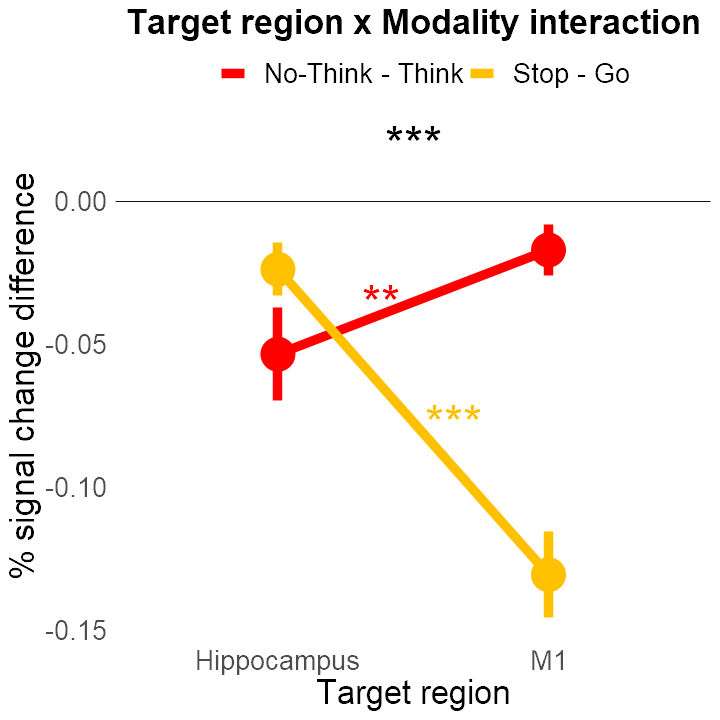

In [30]:
options(repr.plot.width = 6, repr.plot.height = 6) # change plot size
p1

## Target region x Modality ANOVA

In [31]:
summary.anova
res.txt.anova


Error: sid
          Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 23 0.1488 0.006468               

Error: sid:roi
          Df  Sum Sq  Mean Sq F value   Pr(>F)    
roi        1 0.02966 0.029657   14.55 0.000891 ***
Residuals 23 0.04688 0.002038                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: sid:modality
          Df  Sum Sq Mean Sq F value Pr(>F)   
modality   1 0.04216 0.04216   8.733 0.0071 **
Residuals 23 0.11104 0.00483                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: sid:roi:modality
             Df  Sum Sq Mean Sq F value   Pr(>F)    
roi:modality  1 0.12300  0.1230   53.45 1.94e-07 ***
Residuals    23 0.05293  0.0023                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "F(1,23) = 53.45, p = 0.0000002"

### Downregulation of Hippocampus vs M1 for Memory modality

In [32]:
res.ntt
res.txt.ntt


	Paired t-test

data:  data.ntt.rHC$PSC and data.ntt.lM1$PSC
t = -2.874, df = 23, p-value = 0.008574
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.06266344 -0.01021008
sample estimates:
mean of the differences 
            -0.03643676 


[1] "t(23) = 2.87, p = 0.009, d = 0.587"

### Downregulation of Hippocampus vs M1 for Action modality

In [33]:
res.sg
res.txt.sg


	Paired t-test

data:  data.sg.rHC$PSC and data.sg.lM1$PSC
t = 7.5309, df = 23, p-value = 1.19e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.07742116 0.13606259
sample estimates:
mean of the differences 
              0.1067419 


[1] "t(23) = 7.53, p = 0.0000001, d = 1.537"

# Below baseline activity in Hippocampus and M1

In [34]:
# ----------------------------------------------------------------------
# PLOT FIRs
# ----------------------------------------------------------------------
plotFirs <- function(dataset, labelstxt, title) {
  # aggregate
  res <-
    summarySEwithin(
      dataset,
      measurevar = "psc",
      withinvars = c("seconds", "inhibit"),
      idvar = "sid",
      na.rm = TRUE,
      conf.interval = 0.95
    )
  # plot
  ggplot(data = res, aes(x = seconds, y = psc, group = inhibit)) +
    geom_hline(aes(yintercept = 0), size = 0.2) +
    geom_line(size = 1.5, aes(color = inhibit)) +
    geom_ribbon(
      aes(
        ymin = psc - se,
        ymax = psc + se,
        x = seconds,
        fill = inhibit
      ),
      alpha = 0.3,
      show.legend = FALSE
    ) +
    geom_line(aes(x = seconds, y = psc - se, color = inhibit), size = 0.2) +
    geom_line(aes(x = seconds, y = psc + se, color = inhibit), size = 0.2) +
    scale_color_manual(labels = labelstxt, values = c('green', 'blue')) +
    scale_fill_manual(values = c('#14b814', '#2e599e')) +
    scale_x_discrete(labels = c("0", "2", "4", "6", "8", "10")) +
    labs(x = "Peristimulus time (s)", y = "% signal change") +
    ggtitle(title) +
    guides(color = guide_legend("")) +
    theme_minimal() +
    theme(
      legend.position = "top",
      text = element_text(size = 20),
      plot.title = element_text(
        hjust = 0.5,
        size = 20,
        face = "bold"
      ),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank()
    )
}

p2 <- plotFirs(dataLong.lM1SG, c("Go", "Stop"), "Go/Stop, M1")
p3 <- plotFirs(dataLong.rHCTNT, c("Think", "No-Think"), "Think/No-Think, Hippocampus")

# Add one-tailed significance for > or < baseline
lm1s <- subset(data, roi == 'lM1' & condition == 's')
lm1s$PSC <- rowMeans(lm1s[, 5:8])
p.lm1s <- stars.pval(sapply(c(5:8), function(x) {
  t.test(lm1s[, x], mu = 0, alternative = c("less"))$p.value
}))
lm1g <- subset(data, roi == 'lM1' & condition == 'g')
lm1g$PSC <- rowMeans(lm1s[, 5:8])
p.lm1g <- stars.pval(sapply(c(5:8), function(x) {
  t.test(lm1g[, x], mu = 0, alternative = c("greater"))$p.value
}))

rhcnt <- subset(data, roi == 'rHC' & condition == 'nt')
rhcnt$PSC <- rowMeans(rhcnt[, 5:8])
p.rhcnt <- stars.pval(sapply(c(5:8), function(x) {
  t.test(rhcnt[, x], mu = 0, alternative = c("less"))$p.value
}))

rhct <- subset(data, roi == 'rHC' & condition == 't')
rhct$PSC <- rowMeans(rhct[, 5:8])
p.rhct <- stars.pval(sapply(c(5:8), function(x) {
  t.test(rhct[, x], mu = 0, alternative = c("greater"))$p.value
}))

sstypos <-
  summarySEwithin(
    dataLong.lM1SG,
    measurevar = "psc",
    withinvars = c("seconds", "inhibit"),
    idvar = "sid",
    na.rm = TRUE,
    conf.interval = 0.95
  )
p2 <- p2 +
  annotate(
    "text",
    y = min(sstypos$psc) - mean(sstypos$ci),
    x = 2:5,
    label = p.lm1s,
    size = 10, color = "blue"
  ) +
  annotate(
    "text",
    y = max(sstypos$psc) + mean(sstypos$ci),
    x = 2:5,
    label = p.lm1g,
    size = 10, color = "green"
  )

tntypos <-
  summarySEwithin(
    dataLong.rHCTNT,
    measurevar = "psc",
    withinvars = c("seconds", "inhibit"),
    idvar = "sid",
    na.rm = TRUE,
    conf.interval = 0.95
  )
p3 <- p3 +
  annotate(
    "text",
    y = min(tntypos$psc) - mean(tntypos$ci),
    x = 2:5,
    label = p.rhcnt,
    size = 10, color = "blue"
  ) +
  annotate(
    "text",
    y = max(tntypos$psc) + mean(tntypos$ci),
    x = 2:5,
    label = p.rhct,
    size = 10, color = "green"
  )

## FIR plots

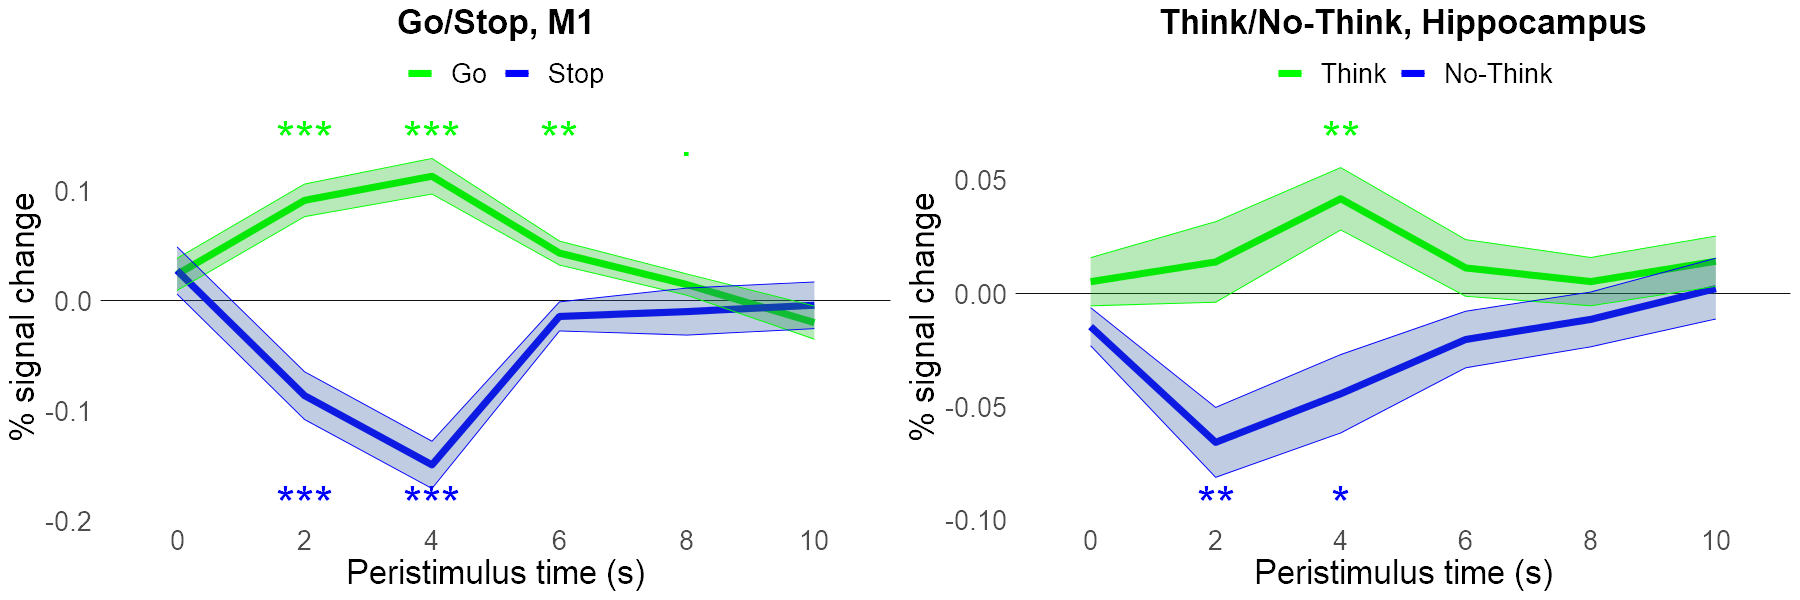

In [35]:

options(repr.plot.width = 15, repr.plot.height = 5)
grid.arrange(p2, p3, nrow=1)

## M1 below baseline during Stop

In [36]:
data.s.lM1 = subset(data, condition == "s" & roi == "lM1")
data.s.lM1$PSC <- rowMeans(data.s.lM1[, 5:8])
tt_sm1 <- t.test(data.s.lM1$PSC, mu = 0, alternative = "less")

sprintf('t(%d) = %.2f, p = %.4f, d = %.3f', 
        tt_sm1$parameter,
        tt_sm1$statistic,
        tt_sm1$p.value,
        abs(tt_sm1$statistic/sqrt(tt_sm1$parameter+1))
)

[1] "t(23) = -3.88, p = 0.0004, d = 0.792"

## Hippocampus below baseline during No-Think

In [37]:
data.nt.rHC = subset(data, condition == "nt" & roi == "rHC")
data.nt.rHC$PSC <- rowMeans(data.nt.rHC[, 5:8])
tt_nthc <- t.test(data.nt.rHC$PSC, mu = 0, alternative = "less")

sprintf('t(%d) = %.2f, p = %.3f, d = %.3f', 
        tt_nthc$parameter,
        tt_nthc$statistic,
        tt_nthc$p.value,
        abs(tt_nthc$statistic/sqrt(tt_nthc$parameter+1))
)

[1] "t(23) = -2.06, p = 0.025, d = 0.421"

# Pattern classification results

In [38]:
library(ggplot2)   # for plotting results
library(gridExtra) # for adding plots together
library(grid)      # for plot grid title formatting
library(gtools)    # for converting pvalues to stars
library(plyr)      # for ddply (aggregating SST results)

df <-
  read.csv(
    'https://raw.githubusercontent.com/dcdace/tmp/master/data/cross_decoding.csv',
    fileEncoding = "UTF-8-BOM"
  )
df$acc <- df$acc * 100
df$roi <- factor(df$roi, levels = c('rdlpfc', 'rvlpfc', 'rHC', 'lM1'))

# create subsets
ntnt   <- subset(df, df$type == 'ntnt')
ss     <- subset(df, df$type == 'ss')
ntssnt <- subset(df, df$type == 'ntssnt')

nrois <- length(levels(df$roi))

# t-test function
dottest <- function(data) {
  test <- t.test(data$acc, mu = 50, alternative = 'greater')
  
  # correct p-value for number of rois tested and keep max p to 1
  test$p.value <-
    ifelse(test$p.value * nrois > 1, 1, test$p.value * nrois)
  
  return(data.frame(
    tval = test$statistic,
    df   = test$parameter[1],
    pval = test$p.value,
    M    = mean(data$acc),
    std = sd(data$acc)
  ))
}

# do ttests per ROI for each subset of dataset
tres <- sapply(list(ntnt, ss, ntssnt), function(x) {
  ddply(x, .(roi), dottest)
})

# get stars for pvalues
sig <- sapply(seq(1:3), function(x) {
  stars.pval(tres[, x]$pval)
})

# PLOTTING MEANS, Group mean with SE and subject values
# ------------------------------------
plotResults <-
  function(dataset, x, group, title, units, extraTxt, nf, fillcolor) {
    ggplot(dataset, aes(group, x)) +
      geom_point(
        colour = "black", alpha = .7, fill = 'grey', size = 3, stroke = 0.5, shape = 21,
        position = position_jitter(height = 0, width = 0.05)
      ) +
      stat_summary(
        fun.data = mean_se,
        geom = "pointrange",
        fill = fillcolor,
        alpha = 1, color = "black", size = 1.5, stroke = 0.5, shape = 21,
        position = position_nudge(x = -0.1)
      ) +
      scale_y_continuous(limits = c(20, 100),
                         breaks = seq(0, 100, 20)) +
      labs(x = extraTxt, y = units) + ggtitle(title) +
      scale_x_discrete(labels = c(
        paste(sig[1, nf], "DLPFC", sep = "\n"),
        paste(sig[2, nf], "VLPFC", sep = "\n"),
        paste(sig[3, nf], "H", sep = "\n"),
        paste(sig[4, nf], "M1", sep = "\n")
      )) +
      theme_minimal() +
      theme(
        text = element_text(size = 22),
        plot.title = element_text(
          size = 20, face = "bold", hjust = 0.5
        ),
        plot.background = element_rect(
          color = "lightgrey", size = 0.4, linetype = "dotted"
        ),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()
      )
  }

p.ntnt <- plotResults(ntnt, ntnt$acc, ntnt$roi,
              "No-Think <-> No-Think", "Classification accuracy (%)", "",
              1, "red") + geom_hline(aes(yintercept = 50))
p.ss <- plotResults(ss, ss$acc, ss$roi, 
              "Stop <-> Stop", "Classification accuracy (%)", "", 
              2, "#ffc000") + geom_hline(aes(yintercept = 50))
p.cross <- plotResults(ntssnt, ntssnt$acc, ntssnt$roi,
              "Stop <-> No-Think", "Classification accuracy (%)", "",
              3, "#ff00ff") + geom_hline(aes(yintercept = 50))

dispresults <- function(res) {
  txt <- lapply(seq(1:4), function(r) {
    sprintf(
      "%s: M = %.0f%% (+-%.0f), t(%d) = %.2f, p = %.3f, d = %.3f",
      res$roi[r],
      res$M[r],
      res$std[r],
      res$df[r],
      res$tval[r],
      res$pval[r],
      res$tval[r] / sqrt(res$df[r] + 1)
    )
  })
  txtBind <- (ldply(txt, "rbind", .id = "roi"))
}

## T-test results (>50%, Bonf. corrected for nr of ROIs)

In [39]:
resdf <- 
    cbind(dispresults(tres[, 1]), dispresults(tres[, 2]), dispresults(tres[, 3]))
colnames(resdf) <- 
    c("No-Think <-> No-Think", "Stop <-> Stop", "Stop <-> No-Think")
resdf

No-Think <-> No-Think,Stop <-> Stop,Stop <-> No-Think
<fct>,<fct>,<fct>
"rdlpfc: M = 78% (+-16), t(23) = 8.20, p = 0.000, d = 1.675","rdlpfc: M = 69% (+-14), t(23) = 6.85, p = 0.000, d = 1.398","rdlpfc: M = 57% (+-10), t(23) = 3.48, p = 0.004, d = 0.711"
"rvlpfc: M = 84% (+-17), t(23) = 9.79, p = 0.000, d = 1.998","rvlpfc: M = 79% (+-16), t(23) = 8.48, p = 0.000, d = 1.731","rvlpfc: M = 60% (+-12), t(23) = 3.93, p = 0.001, d = 0.802"
"rHC: M = 70% (+-17), t(23) = 5.78, p = 0.000, d = 1.180","rHC: M = 59% (+-19), t(23) = 2.30, p = 0.062, d = 0.470","rHC: M = 50% (+-9), t(23) = 0.23, p = 1.000, d = 0.046"
"lM1: M = 53% (+-14), t(23) = 1.13, p = 0.542, d = 0.230","lM1: M = 73% (+-15), t(23) = 7.49, p = 0.000, d = 1.528","lM1: M = 48% (+-8), t(23) = -1.15, p = 1.000, d = -0.235"


## Plots

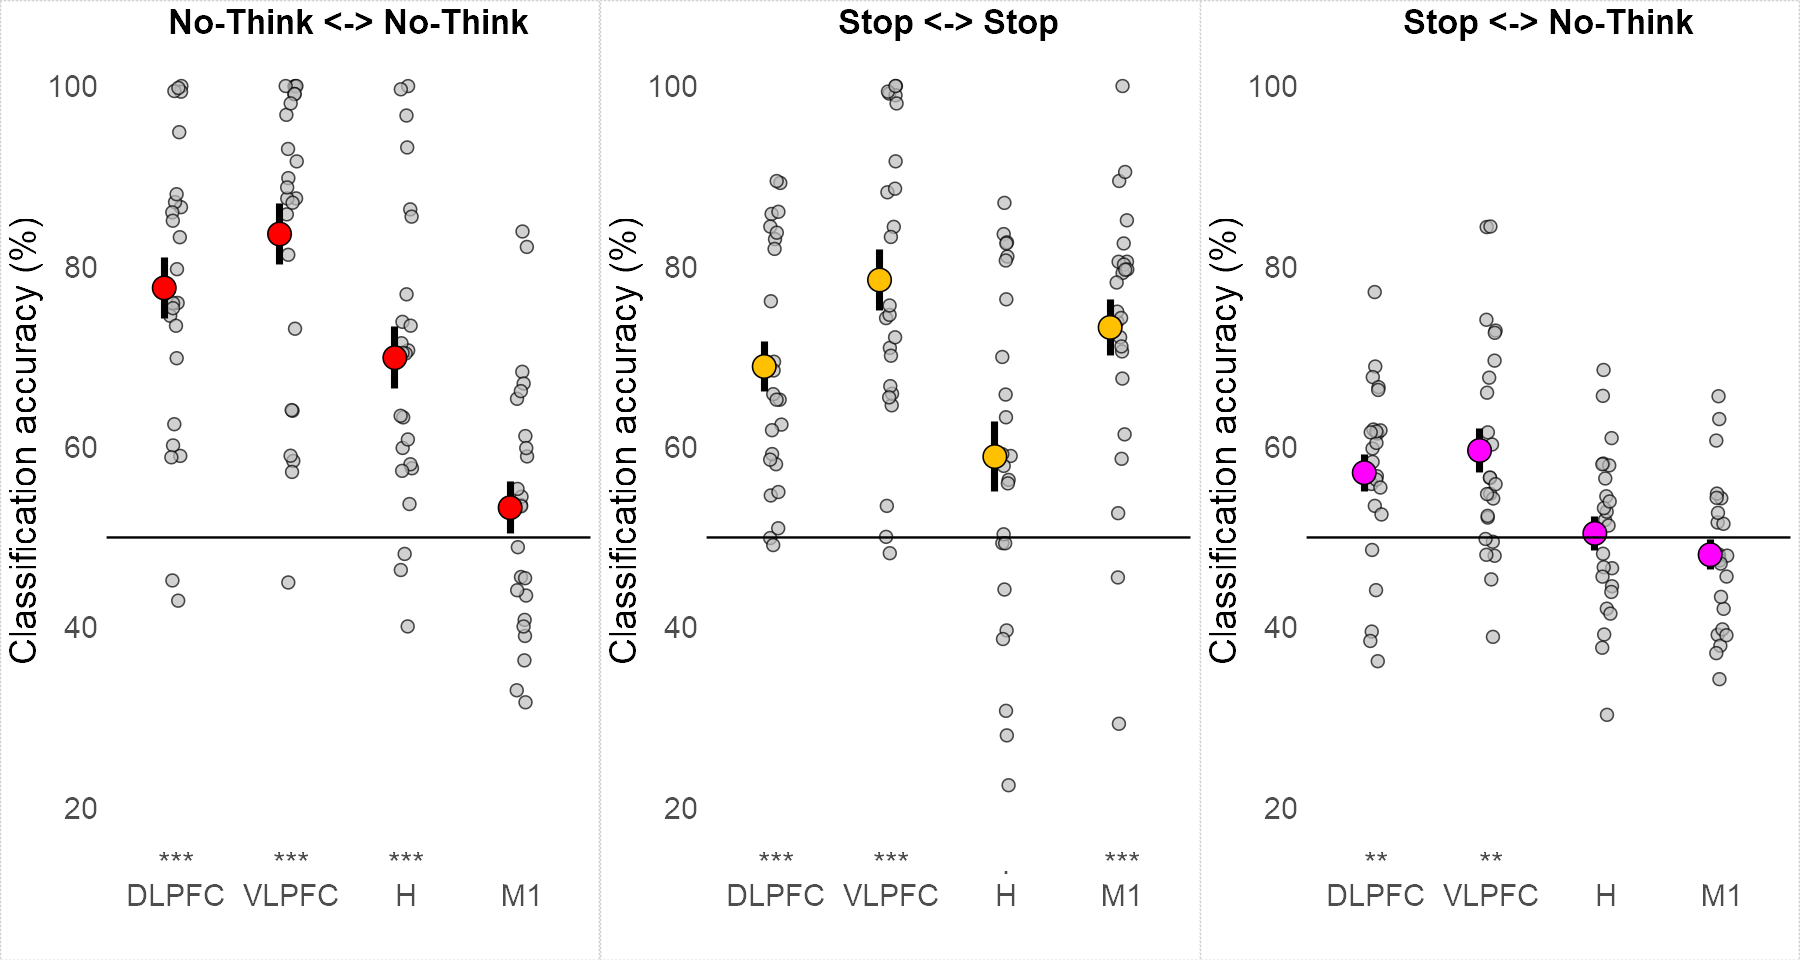

In [40]:
options(repr.plot.width = 15, repr.plot.height = 8)
grid.arrange(p.ntnt, p.ss, p.cross, nrow = 1)

In [41]:
# reset to defult plot size
options(repr.plot.width = 7, repr.plot.height = 7)